[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drscotthawley/DLAIE/blob/main/Lessons/16_VAE.ipynb)

# An Arsenal of Autoencoders: AE, VAE, Conditional VAE, VQ-VAE

Let's see these things in action and see what we can learn in the process. 
--Scott H. Hawley

*Feb 3, 2004: This is a Work In Progress! Code works, but could do with more/better explanations.*

---

## Outline: 
1. Setting Up
1. Autoencoder
1. Varational Autoencoder (VAE)
1. Conditional Variational Autoencoder (C-VAE)
1. Vector-Quantized Varational Autoencoder (VQ-VAE)

# 1. Setup

## Setup Imports

In [1]:
# we'll use pytorch lightning as an alternative to raw pytorch
!pip install -Uqq lightning wandb rich einops

In [2]:
import torch
from torch import nn, optim, utils
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import RichProgressBar
import wandb
import numpy as np
from einops import rearrange

In [3]:
wandb.login()

wandb: Currently logged in as: drscotthawley (strange-quarks). Use `wandb login --relogin` to force relogin


True

## Setup Dataset

MNIST is small and easy and you can do it on a CPU. Let's keep everything super-simple at first: black & white images.

In [4]:
train_ds = MNIST(root='./data', train=True,  download=True, transform=ToTensor())
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
val_ds = test_ds  #alias val & test
print(f"Data set lengths: train: {len(train_ds)}, test: {len(test_ds)}")

Data set lengths: train: 60000, test: 10000


Inspect it a bit..

y (target) = 5 
x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0


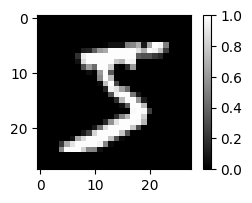

In [5]:
x, y = train_ds[0]   # pick an element
print(f"y (target) = {y} ")

def show_xs(xs, show_stats=True):
    "A little utility we'll call again & again to show one or more images"
    if type(xs) is not list: xs = list(xs)
    ncols = len(xs)
    fig, axs = plt.subplots(figsize=(3*ncols,2), ncols=ncols, squeeze=False)
    ax = axs.ravel()
    for col, x in enumerate(xs):
        if len(x.shape)>2: x = x[0] # remove any batch dimension
        if show_stats:
            if ncols > 1: print(f"col {col}: ",end="")
            print(f"x.shape = {tuple(x.shape)}, min(x) = {torch.min(x)}, max(x) = {torch.max(x)}")
        digit = ax[col].imshow(x.detach().cpu().numpy(), cmap='gray')
        fig.colorbar(digit, ax=ax[col])
    plt.show()

show_xs([x])

Define dataloaders

In [6]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=4, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=4, shuffle=False)
val_dl = test_dl # alias val & test

# 2. Autoencoder


First we'll try a regular autoencoder. Then we'll make it "variational".

For the encoder and decoder, we could use convolutional layers, but MNIST images are small enough that we can get by with using `Linear` layers. 

In [7]:
latent_dim = 3   # more = better reconstructions, but 3 we can plot!

n_hid = [256, 64]  # could imagine adding more layers

act = nn.LeakyReLU # works ok.

encoder = nn.Sequential(  
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[1], latent_dim))

decoder = nn.Sequential(
                nn.Linear(latent_dim, n_hid[1]),
                act(),
                nn.Linear(n_hid[1], n_hid[0]),
                act(),
                nn.Linear(n_hid[0], 28 * 28),
                #nn.Sigmoid(),        # optional. we do want outputs on [0,1]
                )

use_conv=False

z =  tensor([[-0.0222, -0.0767,  0.0879]], grad_fn=<AddmmBackward0>)
x.shape = (28, 28), min(x) = -0.26741576194763184, max(x) = 0.23912005126476288


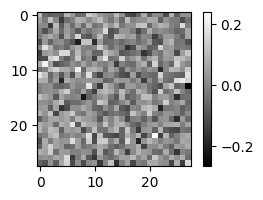

In [8]:
# test it, just to make sure we get no errors from mmult ops
x = x.view(x.size(0), -1)
z = encoder(x)
print("z = ",z)
x_hat = decoder(z)
x_hat = x_hat.view(x.size(0), 28, -1)
show_xs(x_hat)

^^ That was with randomly initialized weights, so we expect a random image. This was just to test that the matrix multiplications work out right.

In [9]:
# instead of nn.Module, we use L.LightningModule
class AEModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

    def do_pred(self, batch, batch_idx):
        x, y = batch
        if not use_conv:
            x = x.view(x.size(0), -1)  # flatten for linear layer
        z, x_hat = self.forward(x)
        loss = nn.functional.mse_loss(x_hat, x) 
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.do_pred(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.do_pred(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

autoencoder = AEModel(encoder, decoder)
model = autoencoder  # alias

In [10]:
wandb.finish()
wandb_logger = WandbLogger(log_model="all", project='ae_tut')
try:
    wandb_logger.watch(model) 
except:
    pass

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [11]:
epochs = 10
trainer = L.Trainer(max_epochs=epochs, devices="auto", logger=wandb_logger)# , callbacks=RichProgressBar(leave=True))
trainer.fit(model=autoencoder, train_dataloaders=train_dl, val_dataloaders=val_dl )
wandb.finish()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 217 K 
1 | decoder | Sequential | 218 K 
--------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss,█▆▄▄▄▄▂▄▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▁▁▂▂▂▂▁▃▂▁▃▃▁▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,9
train_loss,0.03005
trainer/global_step,9379
val_loss,0.03223


z =  tensor([[-0.0222, -0.0767,  0.0879]], grad_fn=<AddmmBackward0>)
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = -0.09859369695186615, max(x) = 1.109294056892395


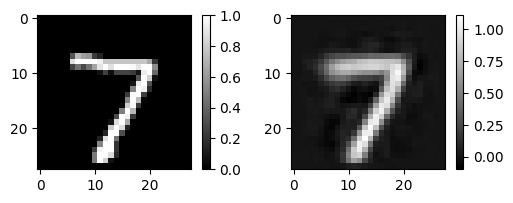

In [12]:
@torch.no_grad()
def test_inference(model, idx=None):
    model.eval()
    "Another utility we'll use for running images through the (V)AE"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x, y = test_ds[idx]
    if not use_conv:
        x = x.view(x.size(0), -1)
    x_hat = model.forward(x)
    x_hat = x_hat[-1]
    if not use_conv:
        x_hat = x_hat.view(x.size(0), -1)
    print("z = ",z)
    x_hat = x_hat.view(x.size(0), 28, -1)
    x = x.view(x.size(0), 28, -1)
    show_xs([x,x_hat])

idx = 0
test_inference(autoencoder, idx=idx)

# 3. Variational Autoencoder (VAE)


**The basic ideas:**

* we force the Decoder to decode points in latent space *nearby* to the point corresponding to the encoded image
* we 'scrunch' the latent space so it looks like a gaussian



To the  the reconstruction loss from before, we will add an extra (and somewhat *competing*) goal: to try to make the distribution of latent space approximately gaussian.  

Because of these two goals, the loss function will not be driven to zero, rather it will be driven to an "equilibrium" between these two different forces (one pulling toward better reconstruction loss, the other toward gaussian-ness.) 


> FUN FACT: We've been using Mean Squared Error for reconstruction loss up to this point, but for the VAE we need to use Binary Cross Entropy (aka Negative Log Likelihood, aka KL Divergence) because we're modeling the *probability distribution* of the outputs.  If we use MSE for reconstruction, we'll just get the mean of the distribution. 

*NB: Here's a good detailed discussion of what's going on in VAEs: https://arxiv.org/abs/2006.10273*

In [13]:
# encoder now spits out mean and variance
vae_encoder = nn.Sequential(
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[1], latent_dim*2), # *2 b/c mu, log_var
                ) 

# decoder is same as before
decoder = nn.Sequential(
                nn.Linear(latent_dim, n_hid[1]),
                act(),
                nn.Linear(n_hid[1], n_hid[0]),
                act(),
                nn.Linear(n_hid[0], 28 * 28),
                nn.Sigmoid(), # optional forcing to [0,1], so we can use BCE loss
                )

In [14]:
# instead of nn.Module, we use L.LightningModule
class VAEModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparam_sample(self, mu, log_var):
        std = torch.exp(0.5*log_var).sqrt() # why the 0.5?
        noise = torch.randn_like(std)       # the "noise"
        return mu + std * noise

    def forward(self, x):
        z = self.encoder(x)
        i_half = z.shape[-1]//2
        mu, log_var = z[:,:i_half],  z[:,i_half:]
        z_hat = self.reparam_sample(mu, log_var)
        x_hat = self.decoder(z_hat)
        return z, mu, log_var, z_hat, x_hat

    def pred_and_log(self, batch, batch_idx, log_prefix=''):
        x, y = batch
        x = x.view(x.size(0), -1)  # flatten for linear layer
        z, mu, log_var, z_hat, x_hat = self.forward(x)   
        
        #recon_loss = nn.functional.mse_loss(x_hat, x)
        recon_loss = nn.functional.binary_cross_entropy(x_hat, x) # remember you need a sigmoid on decoder out to use bce
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        scrunch_factor = 5e-4  # larger means blurrier/blobbier; rescale to get kl & recon similar
        rescaled_kl_loss = (kl_loss * scrunch_factor)
        loss = recon_loss + rescaled_kl_loss
        
        self.log(f'{log_prefix}loss', loss, prog_bar=True)
        self.log(f'{log_prefix}recon_loss', recon_loss)
        self.log(f'{log_prefix}kl_loss', kl_loss)
        self.log(F'{log_prefix}rescaled_kl_loss', rescaled_kl_loss)
        return loss 
        
    def training_step(self, batch, batch_idx):
        return self.pred_and_log(batch, batch_idx, log_prefix='train/')

    def validation_step(self, batch, batch_idx):
        return self.pred_and_log(batch, batch_idx, log_prefix='val/')

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=5e-4)

    def on_epoch_start(self): # give us a new line for each epoch
        print('\n')

vae = VAEModel(vae_encoder, decoder)
model = vae

In [15]:
wandb.finish()
wandb_logger = WandbLogger(log_model="all", project='vae_tut')
wandb_logger.watch(model) # this thing complains too much upon re-runs, just ignore it and keep going

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [16]:
epochs = 10
trainer = L.Trainer(max_epochs=epochs, devices="auto", logger=wandb_logger)# , callbacks=RichProgressBar())# leave=True))
trainer.fit(model=vae, train_dataloaders=train_dl, val_dataloaders=val_dl)
wandb.finish()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 217 K 
1 | decoder | Sequential | 218 K 
---------------------------------------
436 K     Trainable params
0         Non-trainable params
436 K     Total params
1.745     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train/kl_loss,▁▄▆▇▆▆▅▆█▇▆▅▆▆▆▅▆▇▇▅▆▆▆▅▅▆▆▆▇▆▆▆▅▅▅▆▆▅█▆
train/loss,█▅▅▄▃▃▄▃▂▂▃▃▂▃▃▃▂▂▁▁▃▂▁▂▂▂▁▂▁▂▂▁▁▂▂▂▁▁▂▁
train/recon_loss,█▅▅▄▂▃▄▃▂▂▃▃▂▃▃▃▂▂▁▁▃▂▁▂▂▂▁▂▁▂▂▁▁▂▂▂▁▁▂▁
train/rescaled_kl_loss,▁▄▆▇▆▆▅▆█▇▆▅▆▆▆▅▆▇▇▅▆▆▆▅▅▆▆▆▇▆▆▆▅▅▅▆▆▅█▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val/kl_loss,▁▇▄▂▂█▃▄▇▅
val/loss,█▆▄▄▃▂▂▂▁▁
val/recon_loss,█▆▄▄▃▂▂▂▁▁
val/rescaled_kl_loss,▁▇▄▂▂█▃▄▇▅
epoch,9


Doesn't seem like the loss is doing down as we train. Hmmm. Let's try some inference:

z =  tensor([[-0.0222, -0.0767,  0.0879]], grad_fn=<AddmmBackward0>)
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = 5.13603731863323e-19, max(x) = 0.9713922142982483


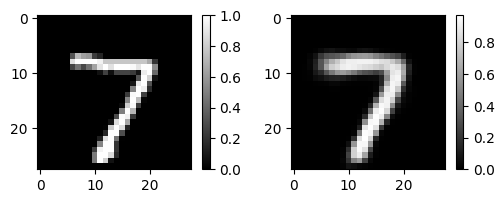

z =  tensor([[-0.0222, -0.0767,  0.0879]], grad_fn=<AddmmBackward0>)
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = 2.9167679556352244e-12, max(x) = 0.8784401416778564


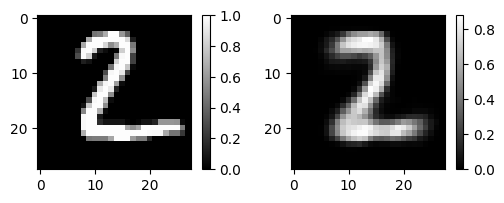

In [17]:
test_inference(vae, idx=0)
test_inference(vae, idx=1)

Looks similar to the regular autoencoder, right?

Now let's try perturbing our input a bit

## Comparing the AE and VAE

Perturbing the regular autoencoder with strength = 5.0:


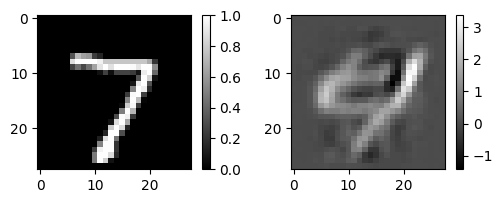

Perturbing the VAE with strength = 5.0:


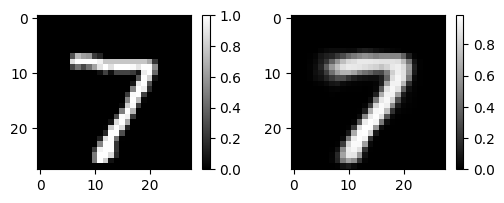

In [18]:
@torch.no_grad()
def infer_perturb(model, idx=None, strength=1.0):
    "Another utility we'll use for running images through the (V)AE"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x, y = test_ds[idx]
    z = model.encoder(x.view(x.size(0), -1))
    if z.shape[-1] > latent_dim: z = z[:,:latent_dim] # if VAE, just use the mean values
    z_hat = z + strength*torch.randn_like(z)
    x_hat = model.decoder(z_hat)
    x_hat = x_hat.view(x.size(0), 28, -1)
    show_xs([x,x_hat], show_stats=False)

idx=0
strength = 5.0
print(f"Perturbing the regular autoencoder with strength = {strength}:")
infer_perturb(autoencoder, idx=idx, strength=strength)
print(f"Perturbing the VAE with strength = {strength}:")
infer_perturb(vae, idx=idx, strength=1.0)

Depending on the random values you get, perturbations may cause the regular AE output to look like not-a-number, whereas the VAE output is probably more stable.

Note that without any final rescaling of outputs (e.g. via `nn.Sigmoid`), typically the output of the regular AE extends wayyy outside the [0,1] intensity bounds whereas the VAE's outputs are still properly bounded.


## Further Investigations: Add interpolation, 3D viz, more.

Make a grid of points in latent space and see what they decode to.

z_hat_batch.shape = torch.Size([225, 3])
grid.shape = torch.Size([3, 452, 452])


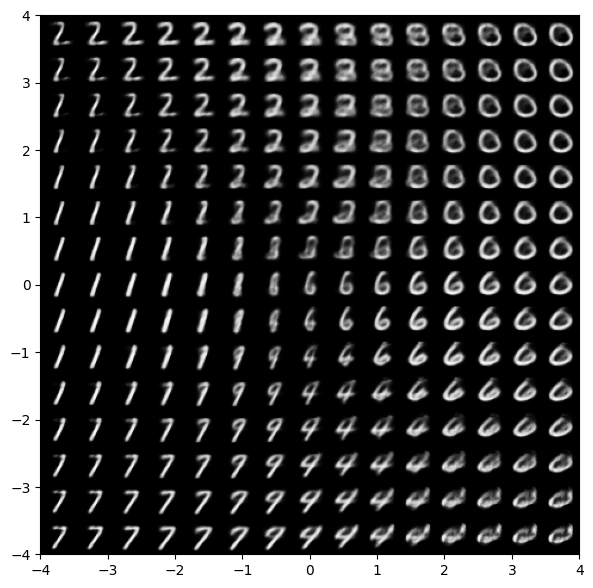

In [19]:
def gen_grid(decoder, xmin=-4, xmax=4, nrow=15):
    zhats = []
    with torch.no_grad():
        for xcoord in torch.linspace(xmin,xmax,nrow):
            for ycoord in torch.linspace(xmin,xmax,nrow):
                z_hat = torch.tensor([xcoord,ycoord,0.0]) # interpolate in a plane
                zhats.append(z_hat)
                
        z_hat_batch = torch.vstack(zhats) # unsqueeze adds dummy color channel
        print("z_hat_batch.shape =",z_hat_batch.shape)
        x_hat = decoder(z_hat_batch)
        x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)
    
    grid = torchvision.utils.make_grid(x_hat, nrow)
    print("grid.shape =",grid.shape)
    
    grid = rearrange(grid, 'c h w -> h w c') 
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(grid.numpy(), extent=(xmin,xmax,xmin,xmax))
    plt.show()

gen_grid(decoder)


# 4. Conditional VAE, i.e. Adding Controls to the VAE


"Conditioning" means attaching controls to the model that, via training, it can learn to associate with specific kinds outputs. For example, we could do "class conditioning" where we tell it what class --- in our case, which digit -- we want the output to be.

The conditioning may take the form of adding or multiplying numbers to the activations, concatenating some controls,...lots of things. One general class of conditioning methods is often referred to as [FiLM layers](https://distill.pub/2018/feature-wise-transformations/), where FiLM stands for **F**eature-w**i**se **L**inear **M**odulation. Essentially it means we will apply our conditioning by both addition and multiplication.

How and where we apply the conditioning is up to us: we could apply it to the encoder, the latent space, and/or the decoder. We could include the conditioning signal in only one spot, or in between all layers. ...It kind of depends on what we want to do.  

We'll take a clue from [StyleGAN2](https://arxiv.org/abs/1912.04958v2) (even though it's a GAN!) and apply our conditioning all throughout the model. 

> TODO: Draw a diagram!

In [20]:
# Here's one way to make a FiLM layer
class FiLM(nn.Module):
    def __init__(self, x_dim, cond_dim):
        super().__init__()
        self.gamma_gen = nn.Linear(cond_dim, x_dim)
        self.beta_gen  = nn.Linear(cond_dim, x_dim)

    def forward(self, x, cond):
        gamma = self.gamma_gen(cond)
        beta  = self.beta_gen(cond)
        return x * gamma + beta

We could do a conditional "regular autoencoder" but it would be kind of boring because whichever digit you ask for, say a 7, it'll just produce the exact same 7 every time.  We want some *variation* to the outputs, so let's make a conditional VAE

In [21]:
# Conditional VAE

latent_dim = 4  

n_hid = [256, 64]  # could imagine adding more layers

act = nn.GELU # this is popular in many models

# should we condition the encoder too?
# doing so may help give structure to the latent space
vae_encoder = nn.Sequential(    # same as before
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[1], 2*latent_dim),
                )

cond_dim = 10  # we'll use one-hot encoding for class conditioning; 10 classes


class EncoderCond(nn.Module):
    def __init__(self, latent_dim, n_hid, cond_dim):
        super().__init__()
        self.l1 = nn.Linear(28*28, n_hid[0])
        self.f1 = FiLM(n_hid[0], cond_dim)
        self.l2 = nn.Linear(n_hid[0], n_hid[1])
        self.f2 = FiLM(n_hid[1], cond_dim)
        self.l3 = nn.Linear(n_hid[1], 2*latent_dim)
        self.act = act()
    def forward(self, x, cond, debug=False):
        x = self.act( self.l1(x) )
        x = self.f1(x,cond)
        x = self.act( self.l2(x) )
        x = self.f2(x, cond)
        x = self.l3(x)
        if debug: print("leaving Encoder, x.shape =",x.shape)
        return x

# Let's try sticking a FiLM before each Linear layer in the Decoder.
# Oh, for the decoder we can't just use nn.Sequential anymore...
class DecoderCond(nn.Module):
    def __init__(self, latent_dim, n_hid, cond_dim):
        super().__init__()
        self.f1 = FiLM(latent_dim, cond_dim)
        self.l1 = nn.Linear(latent_dim, n_hid[1])
        self.f2 = FiLM(n_hid[1], cond_dim)
        self.l2 = nn.Linear(n_hid[1], n_hid[0])
        self.f3 = FiLM(n_hid[0], cond_dim)
        self.l3 = nn.Linear(n_hid[0], 28 * 28)
        self.act = act()

    def forward(self, x, cond, debug=False):
        if debug: print("Debug: 1 x.shape =",x.shape)
        x = self.f1(x, cond)
        x = self.act( self.l1(x) )
        x = self.f2(x, cond)
        x = self.act( self.l2( x ) )
        x = self.f3(x, cond)
        x = self.l3( x )
        x = torch.sigmoid(x) # needed if you want to use BCE loss
        return x

In [22]:
# instead of nn.Module, we use L.LightningModule
class CondVAEModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.ema_loss = 0.06

    def reparam_sample(self, mu, log_var):
        std = torch.exp(0.5*log_var).sqrt() # why the 0.5?
        noise = torch.randn_like(std)       # the "noise"
        return mu + std * noise

    def forward(self, x, cond):
        z = self.encoder(x, cond)
        i_half = z.shape[-1]//2
        mu, log_var = z[:,:i_half],  z[:,i_half:]
        z_hat = self.reparam_sample(mu, log_var)
        x_hat = self.decoder(z_hat, cond)
        return z, mu, log_var, z_hat, x_hat

    def gen(self, y, n_gen=1):
        mu = 4*torch.randn((n_gen, latent_dim))
        log_var = 2*torch.randn((n_gen, latent_dim))
        z_hat = self.reparam_sample(mu, log_var)
        cond = F.one_hot(torch.tensor(y), num_classes=10).float()
        x_hat = self.decoder(z_hat, cond)
        return x_hat

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)  # flatten for linear layer
        cond = F.one_hot(y, num_classes=10).float().to(x.device) # pass in the desired output class as cond

        x_targ, cond_targ = x, cond  # ordinary cond-vae
        use_mixup = False   # mixup seems to 'confuse' the c-vae, makes things blurry.  nah
        if use_mixup: 
            cond_strength = torch.rand((1)).to(x.device)
            # draw x2, y2 values from elsewhere in the batch
            rand_inds = torch.randperm(x.size()[0])
            x2, y2 = x[rand_inds], y[rand_inds]
            x2 = x2.view(x.size(0), -1)
            cond2 = F.one_hot(y2, num_classes=10).float().to(x.device)
            # target is between x and x2, determined by cond_strength
            x_targ    = torch.lerp(x,    x2,    cond_strength)
            cond_targ = torch.lerp(cond, cond2, cond_strength)

        z, mu, log_var, z_hat, x_hat = self.forward(x, cond_targ)

        #recon_loss = nn.functional.mse_loss(x_hat, x_targ)   # mse loss (with no sigmoid on decoder output) destroys variation!
        recon_loss = nn.functional.binary_cross_entropy(x_hat, x_targ) # remember you need a sigmoid on decoder out to use bce
        
        scrunch_factor = 0.001  
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + (kl_loss * scrunch_factor)
        with torch.no_grad():
            self.ema_loss = 0.99*self.ema_loss + 0.01*loss.detach().item()
            self.log('ema_loss', self.ema_loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

In [23]:
vae_encoder_cond = EncoderCond(latent_dim, n_hid, cond_dim)
vae_decoder_cond = DecoderCond(latent_dim, n_hid, cond_dim)
cond_vae = CondVAEModel(vae_encoder_cond, vae_decoder_cond)

epochs = 10
trainer = L.Trainer(max_epochs=epochs, devices="auto")
trainer.fit(model=cond_vae, train_dataloaders=train_dl)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/shawley/envs/dlaie/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Let's take a look at inference:

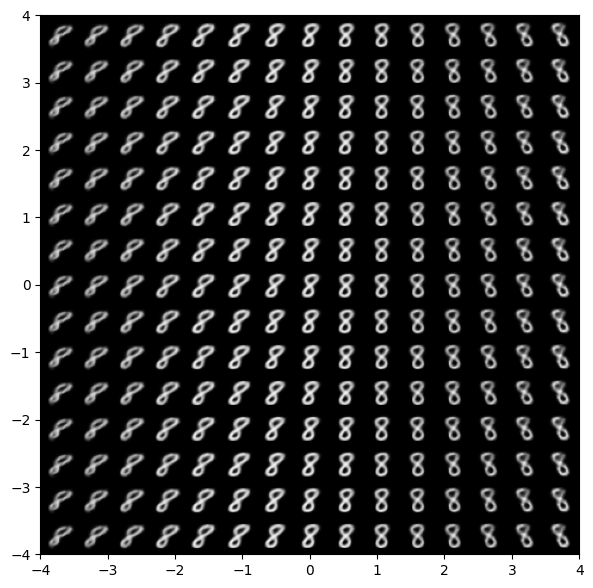

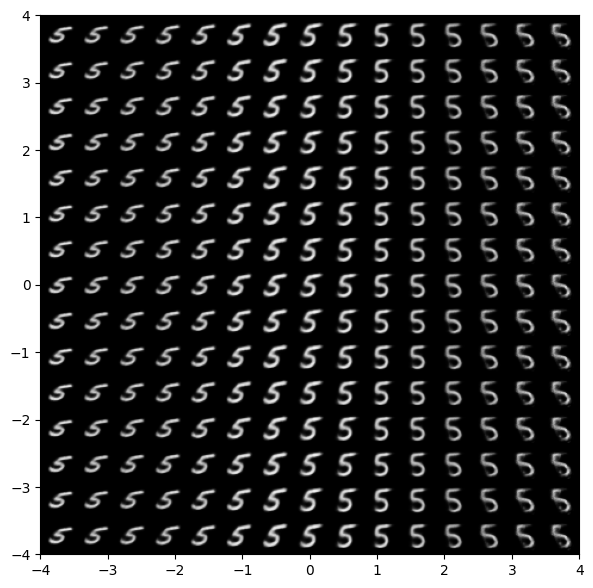

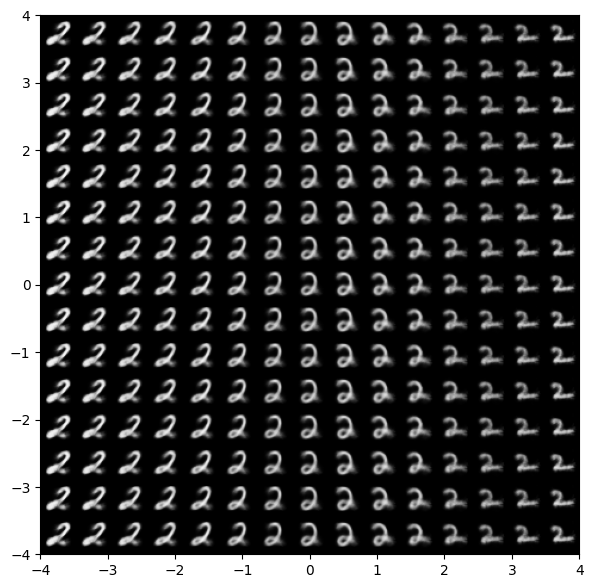

In [24]:
def cond_grid(y):
    cond = F.one_hot(torch.tensor(y), num_classes=10).float()
    nrow = 15
    xmin, xmax = -4,4
    zhats = []
    with torch.no_grad():
        for xcoord in torch.linspace(xmin,xmax,nrow):
            for ycoord in torch.linspace(xmin,xmax,nrow):
                z_hat = torch.tensor([xcoord,ycoord,0.0,0.0])#.to(device)
                zhats.append(z_hat)
                
        z_hat_batch = torch.vstack(zhats).unsqueeze(1) # unsqueeze adds dummy color channel
        x_hat = vae_decoder_cond(z_hat_batch, cond)
        x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)
    
    grid = torchvision.utils.make_grid(x_hat, nrow)
    #print("grid.shape =",grid.shape)
    grid = rearrange(grid, 'c h w -> h w c') 
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(grid.numpy(), extent=(xmin,xmax,xmin,xmax))
    plt.show()

cond_grid(8)
cond_grid(5)
cond_grid(2)

So we see that the latent space we used previously becomes entirely occupied by the digit we condition on, but we get different "properties" of that digit such as tilt, boldness, "font", etc. In other words, *translations in latent space amount to changes in style!*

# 5. Vector Quantized VAE (VQ-VAE)

> Point of Order: I think they should drop the second "V" from "VQ-VAE": in no sense is it variational. It is *not* a VAE, rather it is a VQ-*AE*: it is an autoencoder for which, if you ever try to sample a point in latent space that is not "well defined" by training, then it will deterministically "snap" your latent point to the nearest codebook vector, and deterministically reconstruct from that.  ...BTW, this determinism is why the loss for VQ-VAE is MSE, not BCE! 

For the VAE, we forced the distribution of points in latent space (what the smart people call the "prior" distribution, though some of us see this a "posterior" distribution since it's derived from the data, but I digress) was fixed to be a multidimensional gaussian. 

But, maybe we want something a little more flexible than that. Another way to enforce a tractable probability distribution (i.e. besides assuming it's gaussian) is to quantize it.  So that's what we're going to do. We're basically going to try to cluster points -- "vectors" -- around a finite number of "codebook vectors".  Think of the codebook vectors as "team captains" or "tribal chieftans".  Eventually we'll start using the codebook vectors as "stand-ins" (i.e proxies, i.e.,....some theological term...) for the vectors in their vicinity. Doing so will form the "quantization" we're after. It will be an approximation, but hopefully it'll be so good you won't even notice. If you want to get into it, see the first part of [my blog post on Residual Vector Quantization](https://drscotthawley.github.io/blog/posts/2023-06-12-RVQ.html), which starts by talking about regular VQ.

The trick is going to be handling the quantization in a way that's *differentiable*. You might think "differential quantization" sounds like an oxymoron, and you'd be right. ;-) But there's a cheap workaround that works amazingly well. 

What's going to happen is, when we encode into latent space, we'll replace the point with the *index that points to* the nearest vector in the codebook.  And we'll allow the codebook to evolve as we train.  Note that "nearest to" implies a nearest-neighbor algorithm, which can be slow, but we'll only be using it between one batch of z's at a time and our limited set of codebook vectors. 


## Code
(Best if you just install Lucidrains' [`vector-quantize-pytorch`](https://github.com/lucidrains/vector-quantize-pytorch/blob/146810e271f435daa3834edd9473be050bc04647/vector_quantize_pytorch/vector_quantize_pytorch.py) package instead of my code. ;-) I'm kidding. )

The encoder and decoder will look a lot like our earlier VAE, but the stuff in the middle will change

In [106]:
latent_dim = 4   # more = better reconstructions, but 3 we can plot!

n_hid = [256, 64, 16]  # could imagine adding more layers

act = nn.LeakyReLU # works ok.


encoder = nn.Sequential(
                nn.Linear(28 * 28, n_hid[0]),
                nn.BatchNorm1d(n_hid[0]),  # Adding BatchNorm doesn't really help much tbh, you could take it out.
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                nn.BatchNorm1d(n_hid[1]),
                act(),
                nn.Linear(n_hid[1], n_hid[-1]),
                nn.BatchNorm1d(n_hid[-1]),
                act(),
                nn.Linear(n_hid[-1], latent_dim), # no more mu/log_var b/c it's not a gaussian
                )  

# decoder is same as before
decoder = nn.Sequential(
                nn.Linear(latent_dim, n_hid[-1]),
                nn.BatchNorm1d(n_hid[-1]),
                act(),
                nn.Linear(n_hid[-1], n_hid[1]),
                nn.BatchNorm1d(n_hid[1]),
                act(),
                nn.Linear(n_hid[1], n_hid[0]),
                nn.BatchNorm1d(n_hid[0]),
                act(),
                nn.Linear(n_hid[0], 28 * 28),
                nn.Sigmoid(), # optional forcing to [0,1]
                )


class VQVAEModel(L.LightningModule):
    def __init__(self, encoder, decoder, cb_len=512):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.cb_len = cb_len  # codebook length, e.g. # of classes, or more
        self.cb = nn.Embedding(cb_len, latent_dim) # just a Parameter + initialization. use .weight for values
        # Note: in practice it's best to initialize the codebook self.cb via K-means, but...we're gonna skip that.
        
    def get_nearest_cbv(self, z):
        "get nearest codebook vectors"
        dist = torch.cdist(z, self.cb.weight)
        idx_q = torch.argmin(dist, dim=-1) 
        z_q = self.cb.weight[idx_q]
        return z_q

    def forward(self,x):
        z = self.encoder(x)
        z_q = self.get_nearest_cbv(z)
        z_q_d = z + (z_q - z).detach()    # straight-through estimation; use only to pass to decoder
        x_hat = self.decoder(z_q_d)
        return z, z_q, x_hat
        
    def pred_and_log(self, batch, batch_idx, log_prefix=''):
        x, y = batch
        x = x.view(x.size(0), -1)  
        z, z_q, x_hat = self.forward(x)
        
        recon_loss = 2*F.mse_loss(x_hat, x)        
        cb_loss   = 0.5*F.mse_loss(z.detach(), z_q) 
        beta = 0.1
        comm_loss = F.mse_loss(z,          z_q.detach())  * beta
        loss = recon_loss + cb_loss + comm_loss
        
        self.log(f'{log_prefix}loss', loss, prog_bar=True)
        self.log(f'{log_prefix}recon_loss', recon_loss)
        self.log(F'{log_prefix}cb_loss', cb_loss)
        self.log(F'{log_prefix}comm_loss', comm_loss)
        #print("self.cb.weight = ",self.cb.weight.cpu().detach().numpy())

        return loss 
        
    def training_step(self, batch, batch_idx):
       return self.pred_and_log(batch, batch_idx, log_prefix='train/')

    
    def validation_step(self, batch, batch_idx):
        return self.pred_and_log(batch, batch_idx, log_prefix='val/')

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=5e-3)


vqvae = VQVAEModel(encoder, decoder)
model = vqvae

In [107]:
wandb.finish()
wandb_logger = WandbLogger(log_model="all", project='vqvae_tut')
try:
    wandb_logger.watch(model) # this thing complains too much upon re-runs, just ignore it and keep going
except:
    pass

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [108]:
epochs = 10
trainer = L.Trainer(max_epochs=epochs, devices="auto", logger=wandb_logger)
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)
wandb.finish()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 219 K 
1 | decoder | Sequential | 219 K 
2 | cb      | Embedding  | 2.0 K 
---------------------------------------
441 K     Trainable params
0         Non-trainable params
441 K     Total params
1.765     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train/cb_loss,▁▂▄▄▃▃▄▄▃▄▄▇▅▃▄▅▄▅▅▃▅▄▆▆▆█▅▄▇▄▄▇▅▇▃▇▆▅▆▅
train/comm_loss,▁▂▄▄▃▃▄▄▃▄▄▇▅▃▄▅▄▅▅▃▅▄▆▆▆█▅▄▇▄▄▇▅▇▃▇▆▅▆▅
train/loss,▅▄█▆▂▃▁▃▂▂▁▇▂▂▃▂▅▄▂▃▁▁▄▄▃▆▄▂▅▃▁▅▂▅▁▄▄▄▃▄
train/recon_loss,▇▅█▆▃▄▁▃▃▂▂▅▂▂▃▂▅▄▁▄▁▁▃▃▂▄▄▂▃▃▂▄▁▃▃▂▃▄▂▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val/cb_loss,▂▂▁▆▇▆▆▅▇█
val/comm_loss,▂▂▁▆▇▆▆▅▇█
val/loss,█▆▁▆▆▄▄▂▅▄
val/recon_loss,█▆▃▃▃▂▂▂▂▁
epoch,9


z, z_q = [array([[-1.9076109,  0.4739919,  0.4495523,  1.7342596]], dtype=float32), array([[-2.058491  ,  0.24302599,  0.15163422,  1.8643059 ]],
      dtype=float32)]
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = 2.419802694930695e-05, max(x) = 0.962509274482727


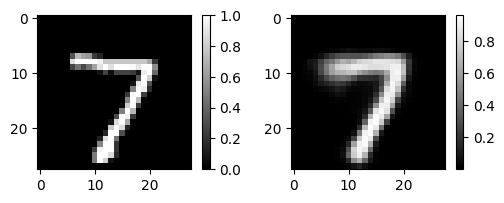

z, z_q = [array([[ 0.06599603,  0.660829  ,  0.9119902 , -1.6219976 ]],
      dtype=float32), array([[-0.35989502,  0.7645864 ,  0.8726427 , -1.724022  ]],
      dtype=float32)]
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = 0.000155487417941913, max(x) = 0.8851152658462524


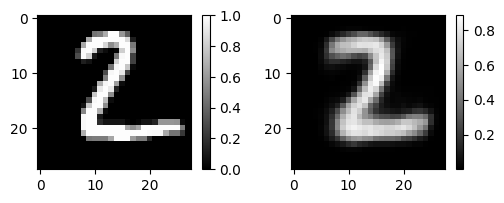

In [109]:
# redo it
@torch.no_grad()
def test_inference2(model, idx=None):
    model.eval()
    "Another utility we'll use for running images through the (V)AE"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x, y = test_ds[idx]
    x = x.view(x.size(0), -1)
    z, z_q, x_hat = model.forward(x)
    print("z, z_q =",[g.detach().cpu().numpy() for g in [z, z_q]])
    x_hat = x_hat.view(x.size(0), 28, -1)
    x = x.view(x.size(0), 28, -1)
    show_xs([x,x_hat])

test_inference2(vqvae, idx=0)
test_inference2(vqvae, idx=1)

z_hat_batch.shape = torch.Size([225, 4])
grid.shape = torch.Size([3, 452, 452])


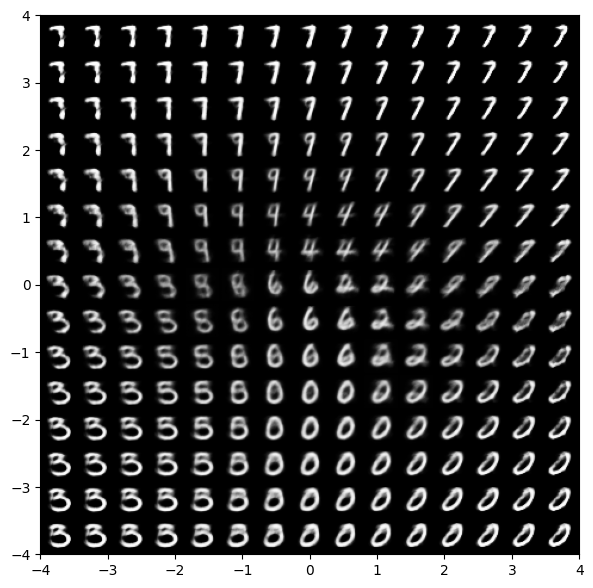

In [110]:
def gen_grid2(decoder, xmin=-4, xmax=4, nrow=15):
    zhats = []
    with torch.no_grad():
        for xcoord in torch.linspace(xmin,xmax,nrow):
            for ycoord in torch.linspace(xmin,xmax,nrow):
                z_hat = torch.tensor([xcoord,ycoord]+[0]*(latent_dim-2)) # interpolate in a plane
                zhats.append(z_hat)
                
        z_hat_batch = torch.vstack(zhats) # unsqueeze adds dummy color channel
        print("z_hat_batch.shape =",z_hat_batch.shape)
        x_hat = decoder(z_hat_batch)
        x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)
    
    grid = torchvision.utils.make_grid(x_hat, nrow)
    print("grid.shape =",grid.shape)
    
    grid = rearrange(grid, 'c h w -> h w c') 
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(grid.numpy(), extent=(xmin,xmax,xmin,xmax))
    plt.show()


gen_grid2(decoder, xmin=-4,xmax=4)

Let's "zoom in" toward the middle of the above picture:

z_hat_batch.shape = torch.Size([225, 4])
grid.shape = torch.Size([3, 452, 452])


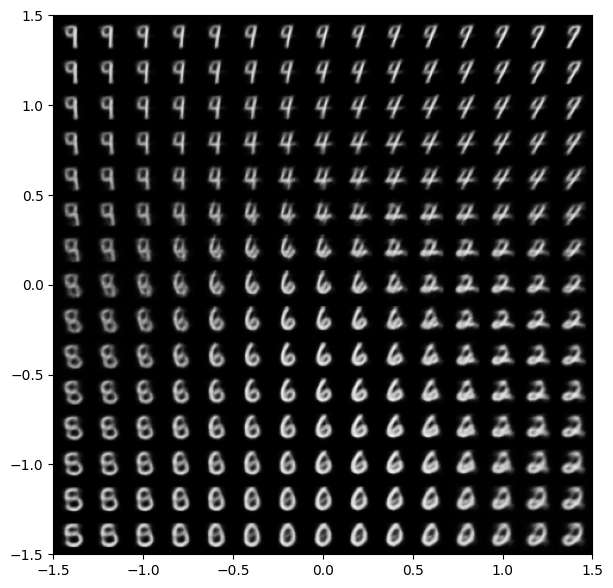

In [111]:
gen_grid2(decoder, xmin=-1.5, xmax=1.5)

You see that it appears as if the latent space is "quantized" by showing regions that repeat the *exact same* image throughout.  You could think of the space as being quantized however I think it's better to think that those are the points which are all nearest to a given codebook vector, and what you're seeing is the reconstruction of that codebook vector serving as a "proxy" for decoding at the other points. 

## For further investigation:
- VQ-VAE dictionary updates with Exponential Moving Averages